### ***1️⃣ Dataset Preparation***

#### 🔶🔸Modules Loading 🔹🔷

In [29]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [31]:
import os
from tqdm import tqdm
import random
import cv2
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, log_loss, roc_auc_score)

In [33]:
# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, GRU, Reshape, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split

In [35]:
# Advanced Deep Learning Libraries 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid,ParameterSampler # For hyperparameter tuning
from tensorflow.keras.regularizers import l1, l2 # For regularization techniques
#import tensorflow_probability as tfp
from sklearn.metrics import classification_report, confusion_matrix
import optuna
from keras_tuner.tuners import Hyperband
from tensorflow.keras.layers import Bidirectional, TimeDistributed, ConvLSTM2D # More advanced layers

#### 🔶🔸Directories Loading 🔹🔷

In [38]:
# Define dataset paths
train_path = "data/split/train"
val_path = "data/split/val"
test_path = "data/split/test"

# --- Define the save path ---
save_dir = "save/no_tune"

In [84]:
# exist_ok prevents error if dir exists
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist
os.makedirs("save/no_tune/gradients", exist_ok=True)

#### 🔶🔸Dataset Loading 🔹🔷

In [11]:
# Function to load images and labels
def load_images_from_folders(base_path, img_size=(64, 64)):
    X, y = [], []
    labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    label_map = {label: i for i, label in enumerate(labels)}

    for case in ["uppercase", "lowercase"]:
        folder_path = os.path.join(base_path, case)
        for letter in os.listdir(folder_path):  # Loop through A-Z and a-z folders
            letter_path = os.path.join(folder_path, letter)
            if os.path.isdir(letter_path):  # Ensure it's a directory
                for img_file in tqdm(os.listdir(letter_path), desc=f"{letter} letters"):
                    img_path = os.path.join(letter_path, img_file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(label_map[letter])
        print("\n")

    X = np.array(X, dtype="float32") / 255.0  # Normalize
    y = to_categorical(np.array(y), num_classes=52)  # Convert labels to one-hot
    return X, y

In [12]:
# Training Data
print("Train Data...")
train_X, train_y = load_images_from_folders(train_path)

# Validation Data
print("Validation Data...")
val_X, val_y = load_images_from_folders(val_path)

# Testing Data
print("Test Data...")
test_X, test_y = load_images_from_folders(test_path)

Train Data...


Z letters: 100%|█████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 8595.14it/s]


z letters: 100%|█████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 5051.81it/s]




Validation Data...


Z letters: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1870.29it/s]


z letters: 100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<?, ?it/s]




Test Data...


Z letters: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2192.91it/s]


z letters: 100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<?, ?it/s]

In [15]:
print("Training Dataset Shape:", train_X.shape, train_y.shape)
print("Validation Dataset Shape:", val_X.shape, val_y.shape)
print("Test Dataset Shape:", test_X.shape, test_y.shape)

Training Dataset Shape: (3640, 64, 64, 3) (3640, 52)
Validation Dataset Shape: (780, 64, 64, 3) (780, 52)
Test Dataset Shape: (780, 64, 64, 3) (780, 52)


### ***2️⃣ Model Selection***

#### 🔶🔸Model Building🔹🔷 

In [35]:
# Custom LeNet-5 Model
def build_lenet5():
    model = Sequential([
        Conv2D(6, kernel_size=(5,5), activation='relu', input_shape=(64,64,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(16, kernel_size=(5,5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dropout(0.3),
        Dense(84, activation='relu'),
        Dropout(0.3),
        Dense(52, activation='softmax')
    ])
    return model

In [36]:
# VGG-16 Transfer Learning Model
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  # Freeze layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(52, activation='softmax')
    ])
    return model

In [37]:
# LSTM Model
def build_lstm():
    model = Sequential([
        Reshape((64, 64*3), input_shape=(64, 64, 3)),
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(128),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(52, activation='softmax')
    ])
    return model

In [38]:
# GRU Model
def build_gru():
    model = Sequential([
        Reshape((64, 64*3), input_shape=(64, 64, 3)),
        GRU(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        GRU(128),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(52, activation='softmax')
    ])
    return model

In [39]:
# LeNet-5 + GRU Model
def build_lenet5_gru(gru_units=128):
    model = Sequential([
        
        # Initial Convolutional block (LeNet-5 style)       
        Conv2D(6, kernel_size=(5,5), activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        
        # Second Convolutional block
        Conv2D(16, kernel_size=(5,5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Third Convolutional block (modified LeNet-5)
        Conv2D(32, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Flatten the feature maps
        Flatten(),

        # Reshape for GRU input:  (timesteps, features)
        Reshape((5, 160)),

        # First GRU layer
        GRU(gru_units, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),

        # Second GRU layer
        GRU(gru_units),
        Dense(84, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(52, activation='softmax')
    ])
    return model

In [40]:
def build_vgg16_gru():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Reshape((256, -1)),
        GRU(128, return_sequences=True),
        GRU(128),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(52, activation='softmax')
    ])
    return model

In [41]:
# Instantiate models
lenet5_model = build_lenet5()
vgg16_model = build_vgg16()
gru_model = build_gru()
lstm_model = build_lstm()
lenet5_gru_model = build_lenet5_gru()
vgg16_gru_model = build_vgg16_gru()

In [42]:
# Training Models
models = {
    "LeNet-5": lenet5_model,
    "VGG-16": vgg16_model,
    "LSTM": lstm_model,
    "GRU": gru_model,
    "LeNet5-GRU": lenet5_gru_model,
    "VGG16-GRU": vgg16_gru_model
}

#### 🔶🔸 Model Architecture Visualization 🔹🔷

In [54]:
# Print model summaries
print("LeNet-5 Model:")
lenet5_model.summary()

LeNet-5 Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 60, 60, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 60, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2704)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │         324,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 52)                  │           4,420 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 342,144 (1.31 MB)

 Trainable params: 342,100 (1.31 MB)

 Non-trainable params: 44 (176.00 B)

In [55]:
print("VGG-16 Model:")
vgg16_model.summary()

VGG-16 Model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,859,380 (56.68 MB)

 Trainable params: 144,692 (565.20 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [56]:
print("LSTM Model:")
lstm_model.summary()

LSTM Model:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 64, 192)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 342,836 (1.31 MB)

 Trainable params: 342,580 (1.31 MB)

 Non-trainable params: 256 (1.00 KB)

In [60]:
print("GRU Model:")
gru_model.summary()

GRU Model:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 64, 192)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64, 128)             │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,620 (1.03 MB)

 Trainable params: 269,364 (1.03 MB)

 Non-trainable params: 256 (1.00 KB)

In [62]:
print("LeNet-5 - GRU {CNN-RNN} Model:")
lenet5_gru_model.summary()

LeNet-5 - GRU {CNN-RNN} Model:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 60, 60, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 26, 26, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 11, 11, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 5, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 5, 128)              │         111,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 84)                  │          10,836 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 52)                  │           4,420 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,928 (913.78 KB)

 Trainable params: 233,564 (912.36 KB)

 Non-trainable params: 364 (1.42 KB)

In [64]:
print("VGG16 - GRU {CNN-RNN} Model:")
vgg16_gru_model.summary()

VGG16 - GRU {CNN-RNN} Model:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 256, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 256, 128)            │          52,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,913,140 (56.89 MB)

 Trainable params: 198,452 (775.20 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### ***3️⃣ Model Training & Performance***

#### 🔶🔸Model Training🔹🔷 

In [66]:
# Compile models without tuning
models["LeNet-5"].compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
models["VGG-16"].compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
models["LSTM"].compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
models["GRU"].compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
models["LeNet5-GRU"].compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
models["VGG16-GRU"].compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
# Training parameters
epochs_dict = {"LeNet-5": 30, "VGG-16": 25, "LSTM": 40, "GRU": 40, "LeNet5-GRU": 35,"VGG16-GRU": 25}
batch_size_dict = {"LeNet-5": 32, "VGG-16": 16, "LSTM": 64, "GRU": 64, "LeNet5-GRU": 32,"VGG16-GRU": 16}

In [72]:
# Train & Save model without tuning
histories = {}

In [73]:
for model_name, model in models.items():
    print(f"🔹Training {model_name}...🔸\n")
    histories[model_name] = model.fit(train_X, train_y,
                                       validation_data=(val_X, val_y),
                                       epochs=epochs_dict[model_name],
                                       batch_size=batch_size_dict[model_name])

🔹Training LeNet-5...🔸

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.0300 - loss: 4.3573 - val_accuracy: 0.0205 - val_loss: 3.9683
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0412 - loss: 3.8788 - val_accuracy: 0.0423 - val_loss: 3.8883
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0898 - loss: 3.6801 - val_accuracy: 0.0679 - val_loss: 3.7390
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.1470 - loss: 3.3765 - val_accuracy: 0.2013 - val_loss: 3.1824
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.2050 - loss: 3.0319 - val_accuracy: 0.2936 - val_loss: 2.7055
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.2749 - loss: 2.7254 - val_accuracy: 0.3295 - val_loss: 2.6443
Epoch 7/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3235 - loss: 2.4475 - val_accuracy: 0.3846 - val_loss: 2.2092
Epoch 8/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.3796 

#### 🔶🔸Model Performance🔹🔷

In [95]:
# 1. Save the trained models:
for model_name, model in models.items():
    model_filepath = os.path.join(save_dir, f"{model_name}.h5")  # Use .h5 for Keras/TensorFlow
    model.save(model_filepath)  # Save the model
    print(f"Model {model_name} saved to: {model_filepath}")

# 2. Save the training history to CSV:
all_data = []
for model_name, history in histories.items():
    history_data = history.history
    epochs = len(history_data['loss'])
    df = pd.DataFrame(history_data)
    df['epoch'] = range(1, epochs + 1)
    df['model'] = model_name
    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)

csv_filepath = os.path.join(save_dir, "model_performance.csv")
final_df.to_csv(csv_filepath, index=False)
print(f"Training history saved to: {csv_filepath}")

Model LeNet-5 saved to: save/model/no_tune/LeNet-5.h5


Model VGG-16 saved to: save/model/no_tune/VGG-16.h5
Model LSTM saved to: save/model/no_tune/LSTM.h5
Model GRU saved to: save/model/no_tune/GRU.h5


Model LeNet5-GRU saved to: save/model/no_tune/LeNet5-GRU.h5
Model VGG16-GRU saved to: save/model/no_tune/VGG16-GRU.h5
Training history saved to: save/model/no_tune/model_performance.csv


In [97]:
# Function to plot accuracy and loss
def plot_metrics(history, model_name):
    epochs = range(len(history.history['loss']))
    
    # Plot Training & Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r', label="Training Loss")
    plt.plot(epochs, history.history['val_loss'], 'b', label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Over Epochs")
    plt.legend()

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'r', label="Training Accuracy")
    plt.plot(epochs, history.history['val_accuracy'], 'b', label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy Over Epochs")
    plt.legend()

    plt.show()

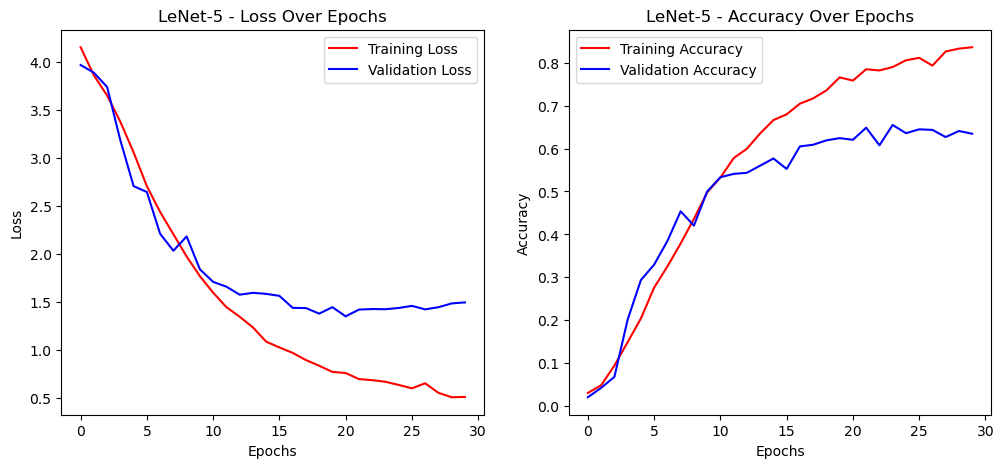

In [99]:
# Visualize 6 models
plot_metrics(histories["LeNet-5"], "LeNet-5")

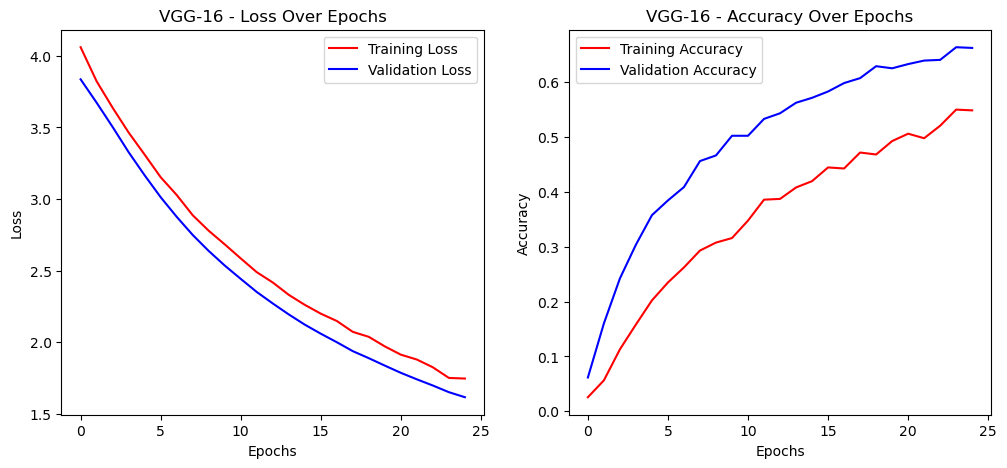

In [100]:
plot_metrics(histories["VGG-16"], "VGG-16")

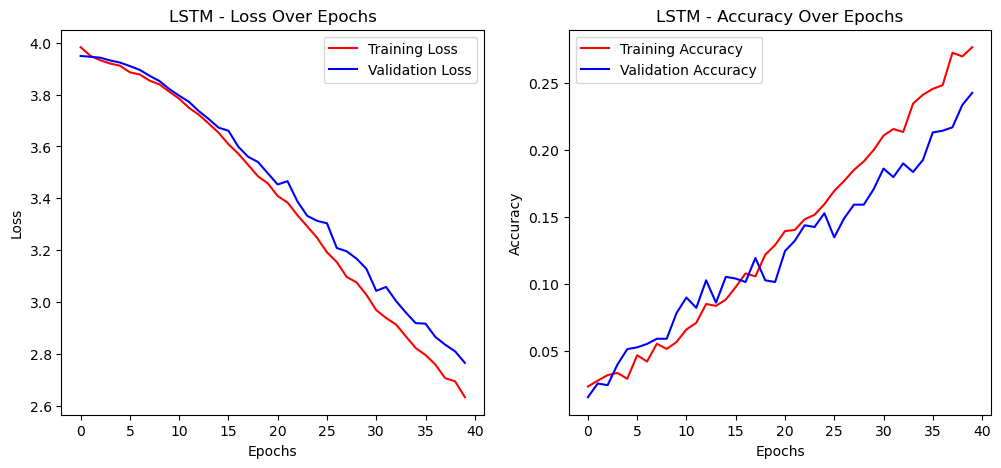

In [101]:
plot_metrics(histories["LSTM"], "LSTM")

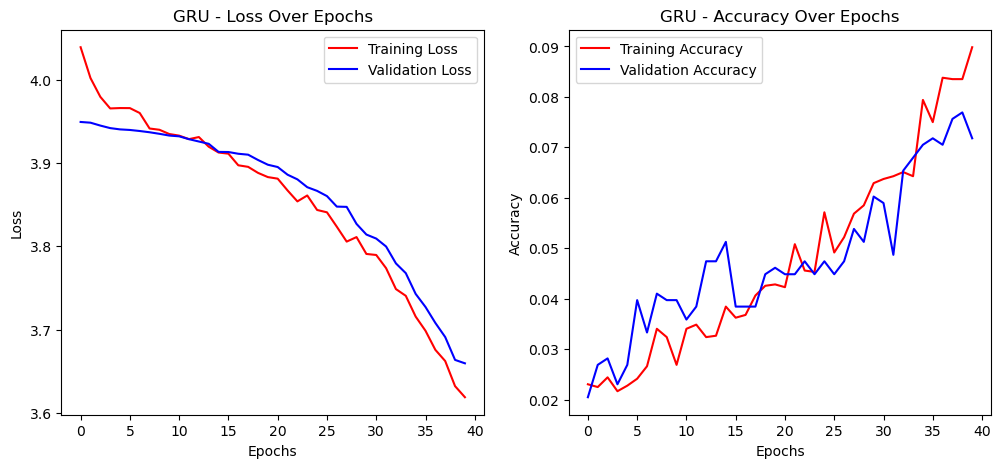

In [102]:
plot_metrics(histories["GRU"], "GRU")

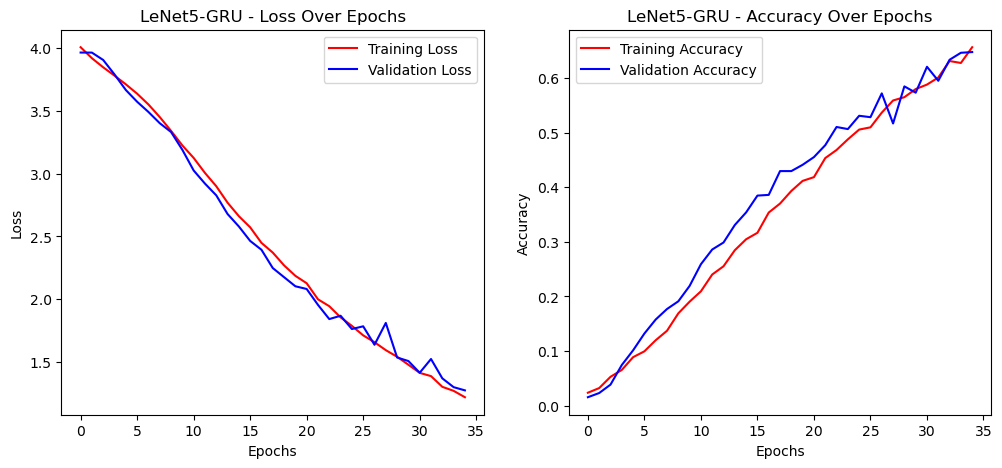

In [103]:
plot_metrics(histories["LeNet5-GRU"], "LeNet5-GRU")

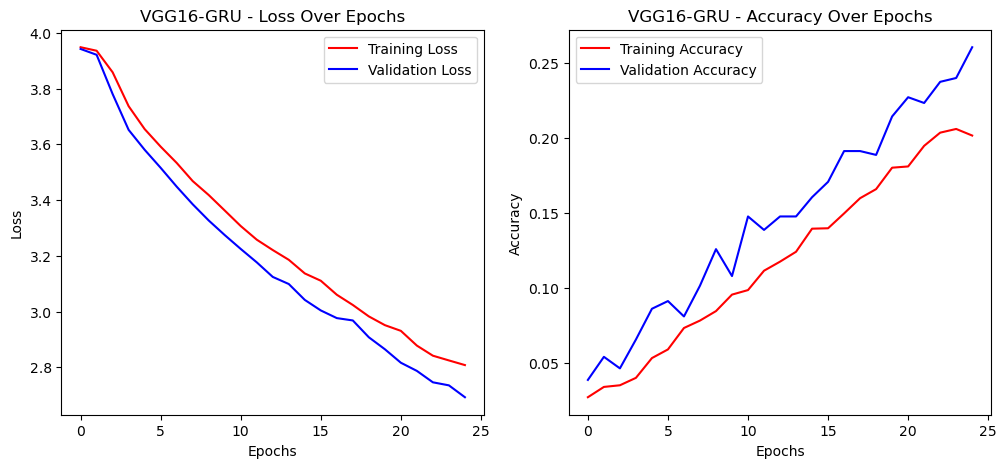

In [104]:
plot_metrics(histories["VGG16-GRU"], "VGG16-GRU")

In [133]:
def plot_all_metrics(histories):
    """Plots training/validation accuracy and loss for all models in separate subplots."""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots

    for model_name, history in histories.items():
        epochs = range(len(history.history['loss']))

        # Plot Training Loss
        axes[0, 0].plot(epochs, history.history['loss'], label=f"{model_name} Training Loss")
        axes[0, 0].set_xlabel("Epochs")
        axes[0, 0].set_ylabel("Loss")
        axes[0, 0].set_title("Training Loss")

        # Plot Validation Loss
        axes[0, 1].plot(epochs, history.history['val_loss'], label=f"{model_name} Validation Loss")
        axes[0, 1].set_xlabel("Epochs")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].set_title("Validation Loss")
        
        # Plot Training Accuracy
        axes[1, 0].plot(epochs, history.history['accuracy'], label=f"{model_name} Training Accuracy")
        axes[1, 0].set_xlabel("Epochs")
        axes[1, 0].set_ylabel("Accuracy")
        axes[1, 0].set_title("Training Accuracy")

        # Plot Validation Accuracy
        axes[1, 1].plot(epochs, history.history['val_accuracy'], label=f"{model_name} Validation Accuracy")
        axes[1, 1].set_xlabel("Epochs")
        axes[1, 1].set_ylabel("Accuracy")
        axes[1, 1].set_title("Validation Accuracy")


    # Add legends to all subplots (outside the loop)
    for ax in axes.flat:
        ax.legend()  # Add a legend to each subplot

    plt.tight_layout() # Adjust subplot params so that subplots fit in to the figure area.
    plt.show()

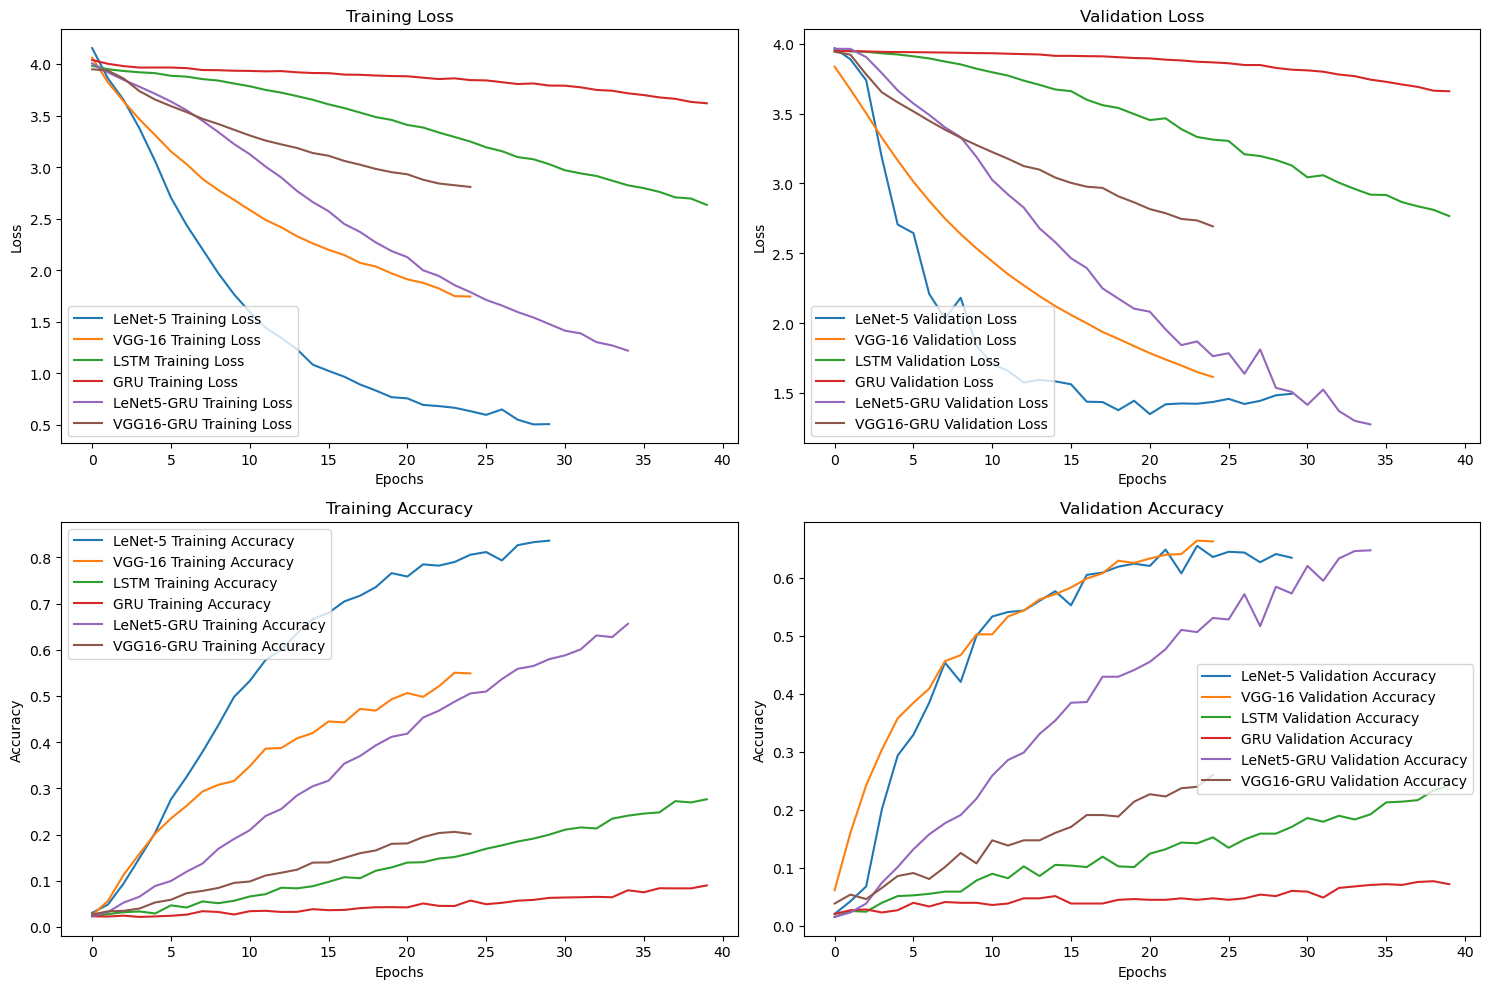

In [135]:
# Example usage:
plot_all_metrics(histories)

#### 🔶🔸Model Saving🔹🔷

In [137]:
def load_all_models(save_dir):
    """Loads all saved models from the specified directory."""

    models = {}
    for filename in os.listdir(save_dir):
        if filename.endswith(".h5"):  # Only load .h5 files
            model_name = filename[:-3]  # Extract model name (remove ".h5")
            model_path = os.path.join(save_dir, filename)
            try:
                model = tf.keras.models.load_model(model_path)
                models[model_name] = model
                print(f"Model {model_name} loaded successfully.")
            except Exception as e:
                print(f"Error loading model {model_name}: {e}")
    return models

In [139]:
loaded_models = load_all_models(save_dir)

Model GRU loaded successfully.


Model LeNet-5 loaded successfully.


Model LeNet5-GRU loaded successfully.
Model LSTM loaded successfully.


Model VGG-16 loaded successfully.


Model VGG16-GRU loaded successfully.


In [141]:
for model_name, model in loaded_models.items():
    print(f"Working with model: {model_name}")

Working with model: GRU
Working with model: LeNet-5
Working with model: LeNet5-GRU
Working with model: LSTM
Working with model: VGG-16
Working with model: VGG16-GRU


### ***4️⃣ Model Testing & Evaluation***

#### 🔶🔸Model Testing🔹🔷

In [24]:
def load_all_models(save_dir):
    """Loads all saved models from the specified directory."""

    models = {}
    for filename in os.listdir(save_dir):
        if filename.endswith(".h5"):  # Only load .h5 files
            model_name = filename[:-3]  # Extract model name (remove ".h5")
            model_path = os.path.join(save_dir, filename)
            try:
                model = load_model(model_path)
                models[model_name] = model
                print(f"Model {model_name} loaded successfully.")
            except Exception as e:
                print(f"Error loading model {model_name}: {e}")
    return models

In [44]:
model_names = ["LeNet-5", "VGG-16", "LSTM", "GRU", "LeNet5-GRU", "VGG16-GRU"]

# Load all models correctly
loaded_models = load_all_models(save_dir)

Model GRU loaded successfully.


Model LeNet-5 loaded successfully.
Model LeNet5-GRU loaded successfully.


Model LSTM loaded successfully.


Model VGG-16 loaded successfully.


Model VGG16-GRU loaded successfully.


In [46]:
labels = {i: chr(65 + i) if i < 26 else chr(97 + (i - 26)) for i in range(52)}

In [48]:
# Predict and store predictions for each model
all_predictions = {}
for name, model in loaded_models.items():  # Iterate through the loaded models dictionary
    try:
        predictions = model.predict(test_X)
        predicted_labels = np.argmax(predictions, axis=1)
        actual_labels = np.argmax(test_y, axis=1)  # Assuming test_y is one-hot encoded
        all_predictions[name] = {"predictions": predictions, "predicted_labels": predicted_labels, "actual_labels": actual_labels}
        print(f"Predictions for {name} completed.")
    except Exception as e:
        print(f"Error making predictions for {name}: {e}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Predictions for GRU completed.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions for LeNet-5 completed.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Predictions for LeNet5-GRU completed.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Predictions for LSTM completed.
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step
Predictions for VGG-16 completed.
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step
Predictions for VGG16-GRU completed.


In [49]:
# Select random images for visualization
num_samples = 30
random_indices = np.random.choice(len(test_X), num_samples, replace=False)

In [50]:
def predict_and_display(model, num_images=5):  # Pass the model as an argument
    indices = random.sample(range(len(test_X)), num_images)
    selected_images = test_X[indices]
    actual_labels = np.argmax(test_y[indices], axis=1)

    predictions = model.predict(selected_images) # Use the passed model
    predicted_labels = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1) * 100

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(selected_images[i].reshape(64,64,3)) # Reshape if needed
        plt.axis("off")
        actual = labels[actual_labels[i]] # Use label_map (more descriptive name)
        predicted = labels[predicted_labels[i]]
        confidence = confidence_scores[i]
        color = "green" if actual == predicted else "red"  # Color-code
        plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence:.2f}%)", color=color, fontsize=12)

    plt.show()

Predictions for GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


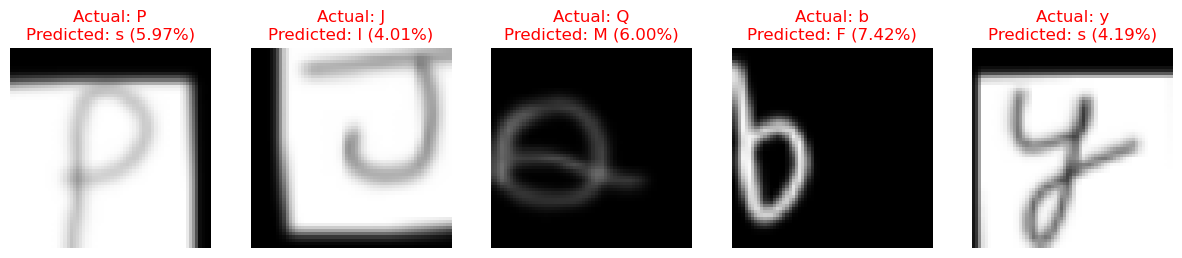

------------------------------------------------------------------------------------------------------------------------------------------------------
Predictions for LeNet-5:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


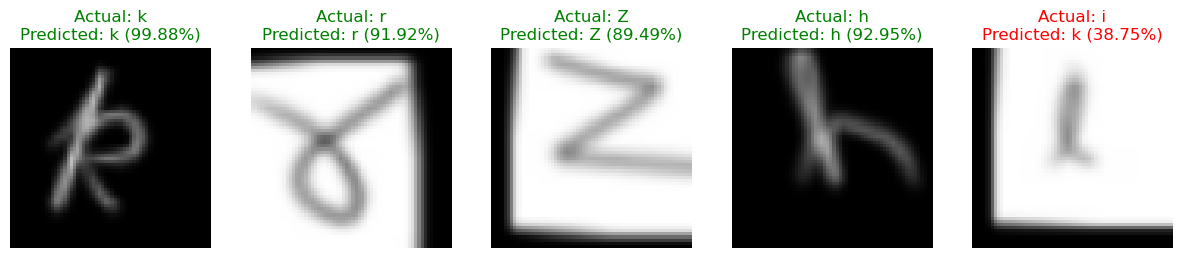

------------------------------------------------------------------------------------------------------------------------------------------------------
Predictions for LeNet5-GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


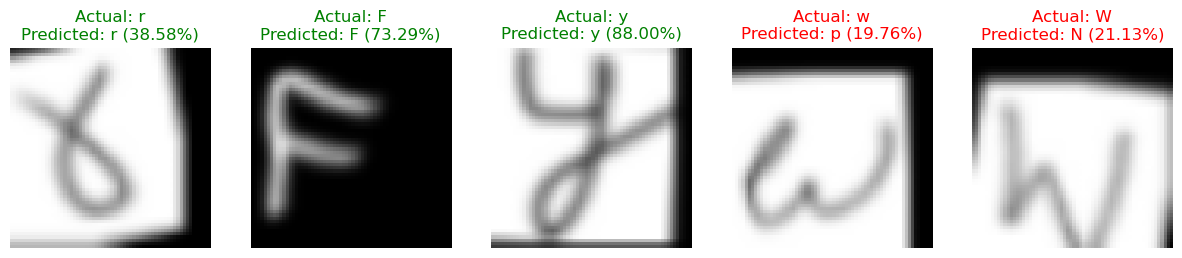

------------------------------------------------------------------------------------------------------------------------------------------------------
Predictions for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


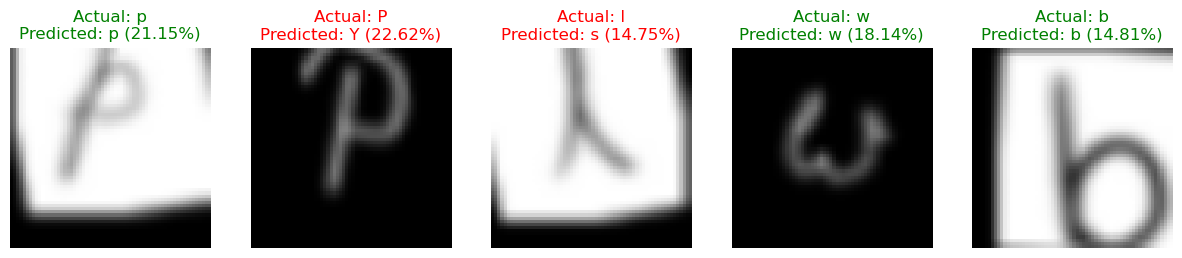

------------------------------------------------------------------------------------------------------------------------------------------------------
Predictions for VGG-16:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


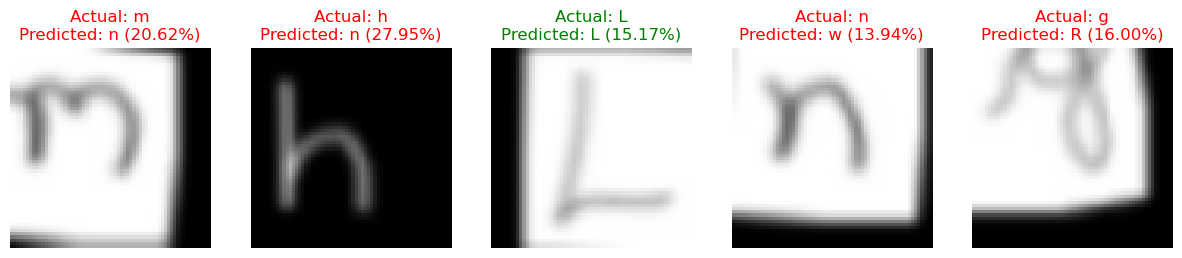

------------------------------------------------------------------------------------------------------------------------------------------------------
Predictions for VGG16-GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


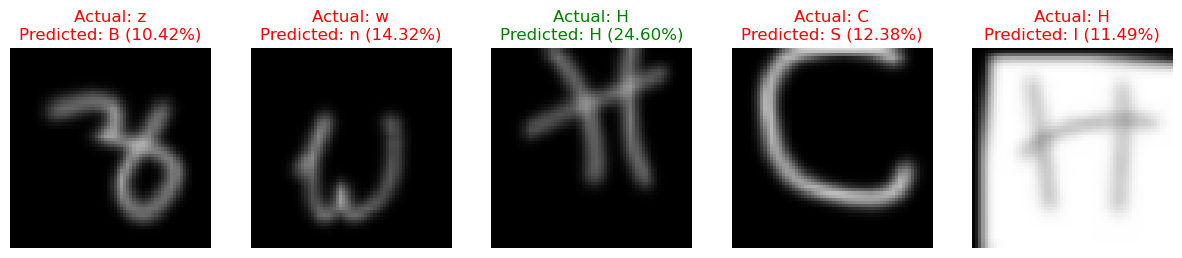

------------------------------------------------------------------------------------------------------------------------------------------------------


In [94]:
# Example usage:
for model_name, model in loaded_models.items(): # Iterate through loaded models
    print(f"Predictions for {model_name}:")
    predict_and_display(model, num_images=5) # Call the function, passing the current model
    print("-" * 150)

In [105]:
def predict_and_display_with_graph(model, num_images=5):  # Pass model object
    num_images = max(1, min(num_images, 10))
    indices = random.sample(range(len(test_X)), num_images)
    selected_images = test_X[indices]
    actual_labels = np.argmax(test_y[indices], axis=1)

    predictions = model.predict(selected_images)
    predicted_labels = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1) * 100

    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images), gridspec_kw={'width_ratios': [1, 1]})

    for i in range(num_images):
        axes[i, 0].imshow(selected_images[i].reshape(64,64,3))  # Reshape if needed
        axes[i, 0].axis("off")
        actual = labels[actual_labels[i]]
        predicted = labels[predicted_labels[i]]
        confidence = confidence_scores[i]
        color = "green" if actual == predicted else "red"
        axes[i, 0].set_title(f"Actual: {actual}\nPredicted: {predicted} ({confidence:.2f}%)", color=color, fontsize=10)

        all_confidences = predictions[i] * 100
        top_5_indices = np.argsort(all_confidences)[-5:][::-1]
        top_5_labels = [labels[idx] for idx in top_5_indices]  # Use label_map
        top_5_scores = [all_confidences[idx] for idx in top_5_indices]

        axes[i, 1].barh(top_5_labels, top_5_scores, color='skyblue')
        axes[i, 1].invert_yaxis()
        axes[i, 1].set_xlim(0, 100)
        axes[i, 1].set_xlabel("Confidence %", fontsize=10)
        axes[i, 1].set_title("Top 5 Predictions", fontsize=10)

    plt.tight_layout()
    plt.show()

In [113]:
def run_predictions():  # Function to encapsulate the entire process
    while True:
        try:
            print("Available Models:")
            for i, model_name in enumerate(loaded_models.keys()):
                print(f"{i+1}. {model_name}")

            model_choice = int(input("Select a model (enter number): ")) - 1
            if 0 <= model_choice < len(loaded_models):
                selected_model_name = list(loaded_models.keys())[model_choice]
                selected_model = loaded_models[selected_model_name]

                while True:
                    try:
                        num_images = int(input("Enter the number of images to display (1-10): "))
                        if 1 <= num_images <= 10:
                            break
                        else:
                            print("Invalid input. Please enter a number between 1 and 10.")
                    except ValueError:
                        print("Invalid input. Please enter an integer.")

                print(f"Predictions for {selected_model_name}:")
                predict_and_display_with_graph(selected_model, num_images)

                # Ask if the user wants to run again
                run_again = input("Do you want to make more predictions? (yes/no): ").lower()
                if run_again != 'yes':
                    break  # Exit the outer loop if the user doesn't want to continue
            else:
                print("Invalid model choice.")
        except (ValueError, IndexError):
            print("Invalid input. Please enter a valid number.")

Available Models:
1. GRU
2. LeNet-5
3. LeNet5-GRU
4. LSTM
5. VGG-16
6. VGG16-GRU


Select a model (enter number):  2
Enter the number of images to display (1-10):  5


Predictions for LeNet-5:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


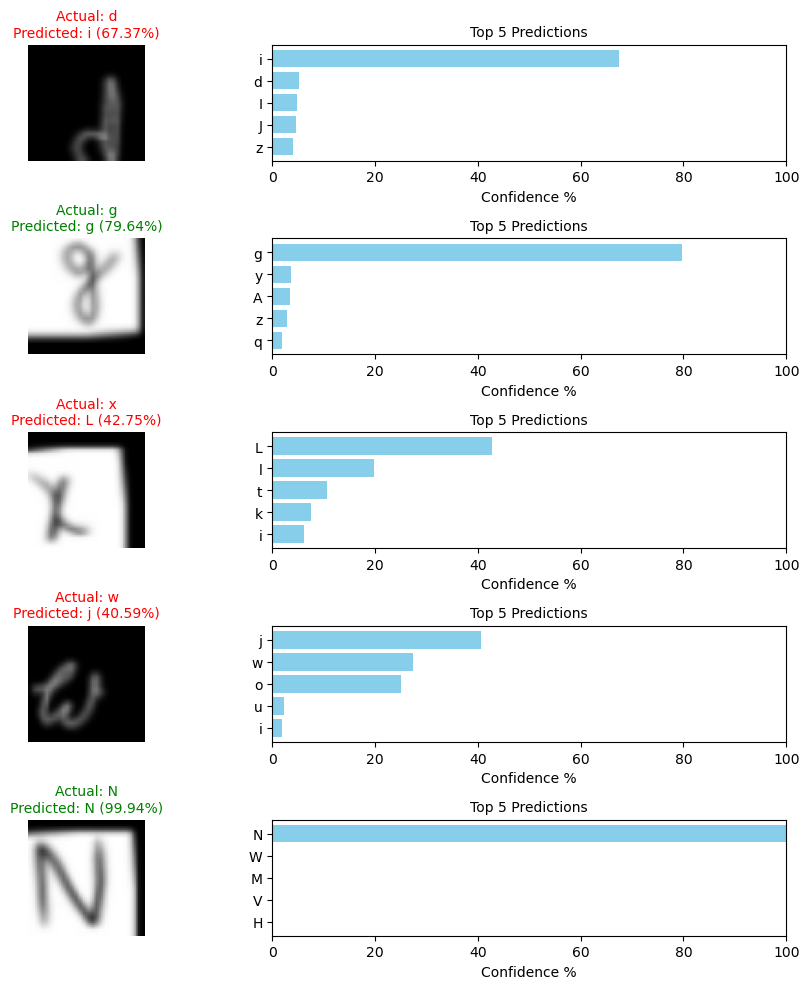

Do you want to make more predictions? (yes/no):  yes


Available Models:
1. GRU
2. LeNet-5
3. LeNet5-GRU
4. LSTM
5. VGG-16
6. VGG16-GRU


Select a model (enter number):  3
Enter the number of images to display (1-10):  5


Predictions for LeNet5-GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


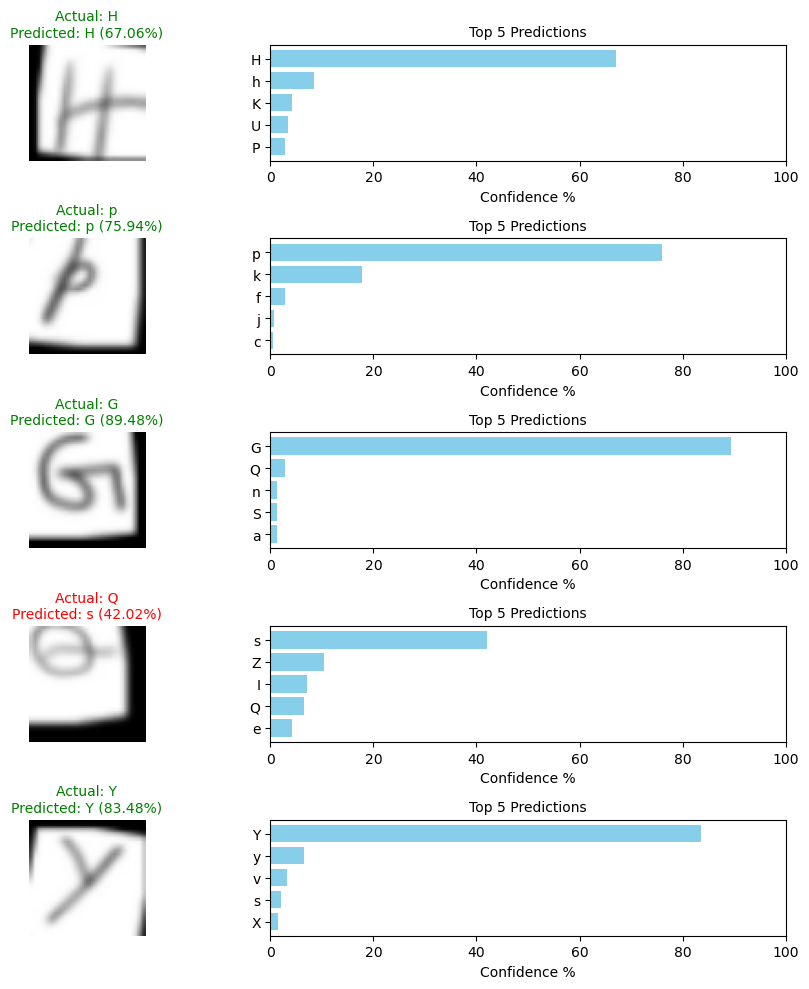

Do you want to make more predictions? (yes/no):  #


In [115]:
run_predictions()

#### 🔶🔸Model Evaluation🔹🔷 

In [80]:
# Function to evaluate model (as provided)
def evaluate_model(model, model_name, X_test, y_test):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    return accuracy, precision, recall, f1, logloss, roc_auc

In [160]:
for name, model in loaded_models.items():  # Iterate through the loaded models dictionary
    print(f"{name} --> {model}")

GRU --> <Sequential name=sequential_2, built=True>
LeNet-5 --> <Sequential name=sequential, built=True>
LeNet5-GRU --> <Sequential name=sequential_4, built=True>
LSTM --> <Sequential name=sequential_3, built=True>
VGG-16 --> <Sequential name=sequential_1, built=True>
VGG16-GRU --> <Sequential name=sequential_5, built=True>


In [82]:
results = {}  # Dictionary to store evaluation results

for name, model in loaded_models.items():  # Iterate through the loaded models dictionary
    try:
        print(f"Evaluating {name}...")
        results[name] = evaluate_model(model, name, test_X, test_y)  # Assuming test_X and test_y are defined
    except Exception as e:
        print(f"Error loading or evaluating model {name}: {e}")

Evaluating GRU...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.07      0.07      0.07        15
           2       0.18      0.60      0.27        15
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        15
           5       0.25      0.27      0.26        15
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00        15
          10       0.20      0.07      0.10        15
          11       0.33      0.07      0.11        15
          12       0.12      0.33      0.18        15
          13       0.25      0.07      0.11        15
          14       0.00      0.00      0.00        15
          15       0.00      0.00      0.00        15


In [83]:
def evaluate_and_plot(model, model_name, X_test, y_test):
    # Evaluation
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    logloss = log_loss(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Log Loss:", logloss)
    print("ROC-AUC:", roc_auc)

    return accuracy, precision, recall, f1, logloss, roc_auc # Return metrics

In [84]:
results = {}  # Store results for DataFrame later (if needed)

for name, model in loaded_models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_and_plot(model, name, test_X, test_y)


Evaluating GRU...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Model: GRU
Accuracy: 0.08461538461538462
Precision: 0.09897928524997678
Recall: 0.08461538461538462
F1-score: 0.06808209330752062
Log Loss: 3.656654973664515
ROC-AUC: 0.7073822691469751

Evaluating LeNet-5...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Model: LeNet-5
Accuracy: 0.632051282051282
Precision: 0.6561662745843503
Recall: 0.632051282051282
F1-score: 0.6283394107002459
Log Loss: 1.4659190071722483
ROC-AUC: 0.9753527735880676

Evaluating LeNet5-GRU...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Model: LeNet5-GRU
Accuracy: 0.6487179487179487
Precision: 0.661734971089877
Recall: 0.6487179487179487
F1-score: 0.6419929381918708
Log Loss: 1.2557464922146178
ROC-AUC: 0.9790464219875985

Evaluating LSTM...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Model: LSTM
Accuracy: 0.26666666666666666
Precision: 0.2760518449915531
Recall: 0.26666666666666666
F1-score: 0.24408070842489174
Log Loss: 2.7102798748925
ROC-AUC: 0.8899312887548183

Evalu

In [94]:
# --- Convert results to DataFrame ---
metrics_df = pd.DataFrame.from_dict(results, orient='index', columns=["Accuracy", "Precision", "Recall", "F1-score", "Log Loss", "ROC-AUC"])

print("\n--- Summary of Model Evaluation Results ---")
display(metrics_df)


--- Summary of Model Evaluation Results ---


,Accuracy,Precision,Recall,F1-score,Log Loss,ROC-AUC
GRU,0.084615,0.098979,0.084615,0.068082,3.656655,0.707382
LeNet-5,0.632051,0.656166,0.632051,0.628339,1.465919,0.975353
LeNet5-GRU,0.648718,0.661735,0.648718,0.641993,1.255746,0.979046
LSTM,0.266667,0.276052,0.266667,0.244081,2.710280,0.889931
VGG-16,0.660256,0.672053,0.660256,0.653011,1.621339,0.980161
VGG16-GRU,0.216667,0.194817,0.216667,0.192974,2.763314,0.883394


In [96]:
# --- Save the DataFrame as CSV ---
file_path = os.path.join(save_dir, "model_evaluation.csv")
metrics_df.to_csv(file_path, index=True)

In [138]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(labels.values()),  # Use labels on x-axis
                yticklabels=list(labels.values()))  # Use labels on y-axis
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


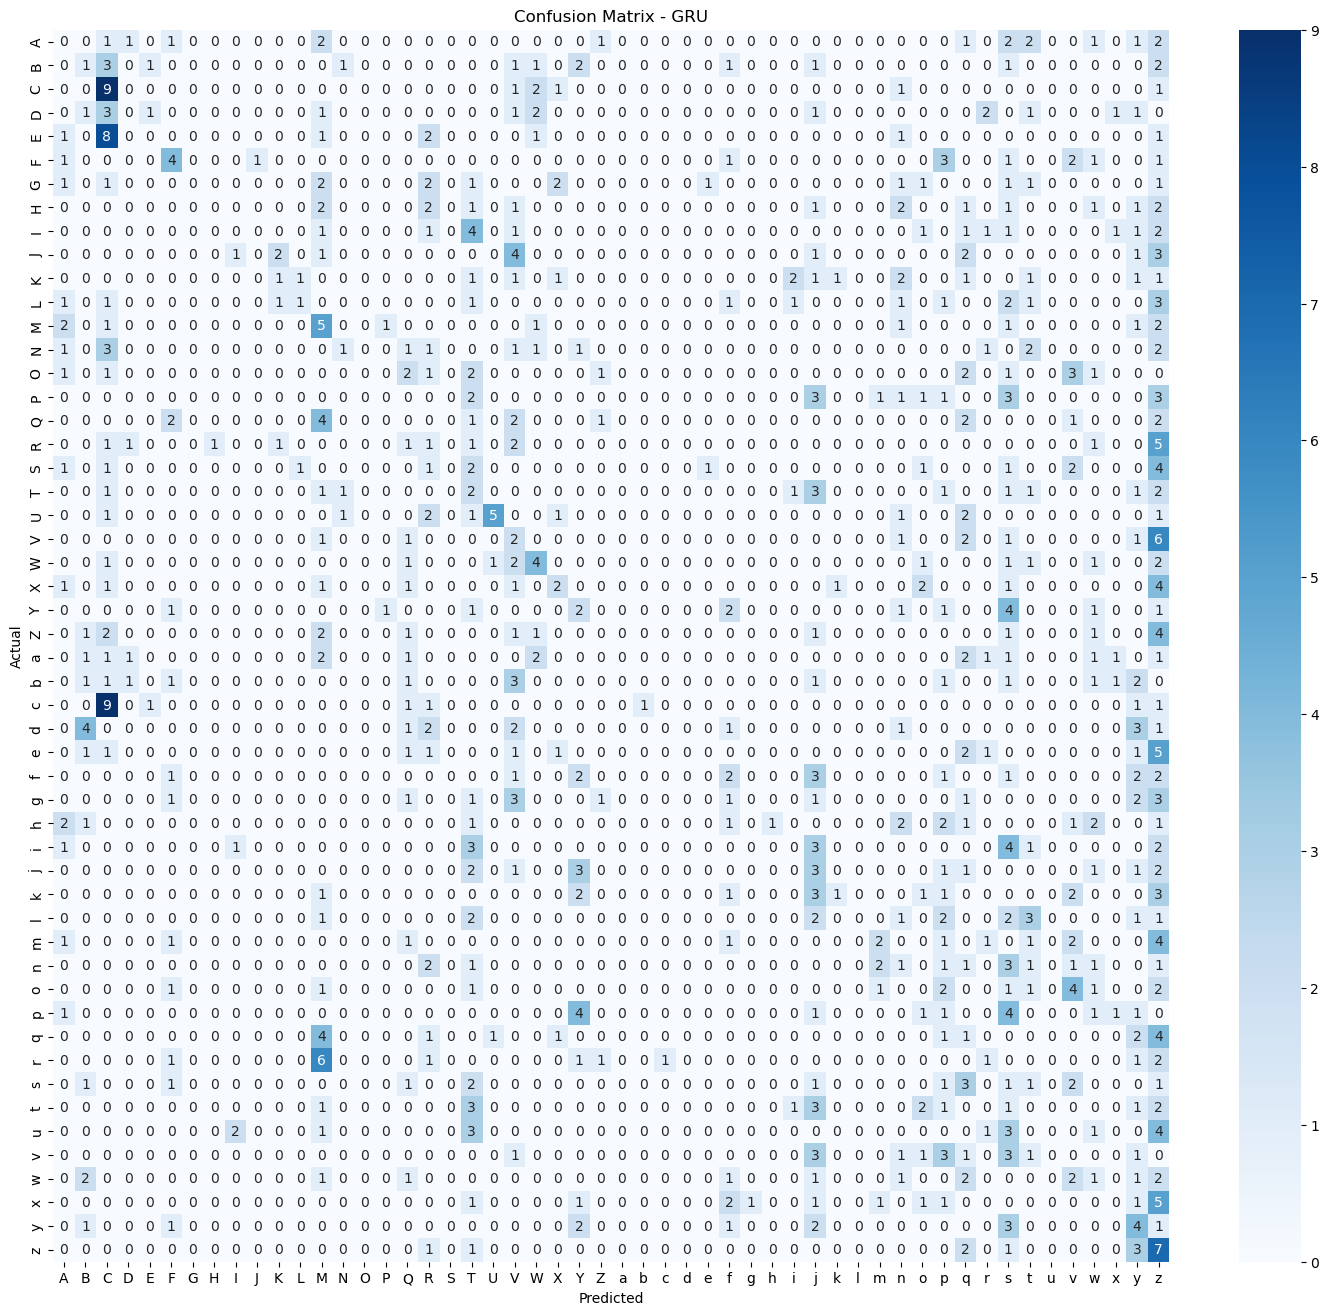

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


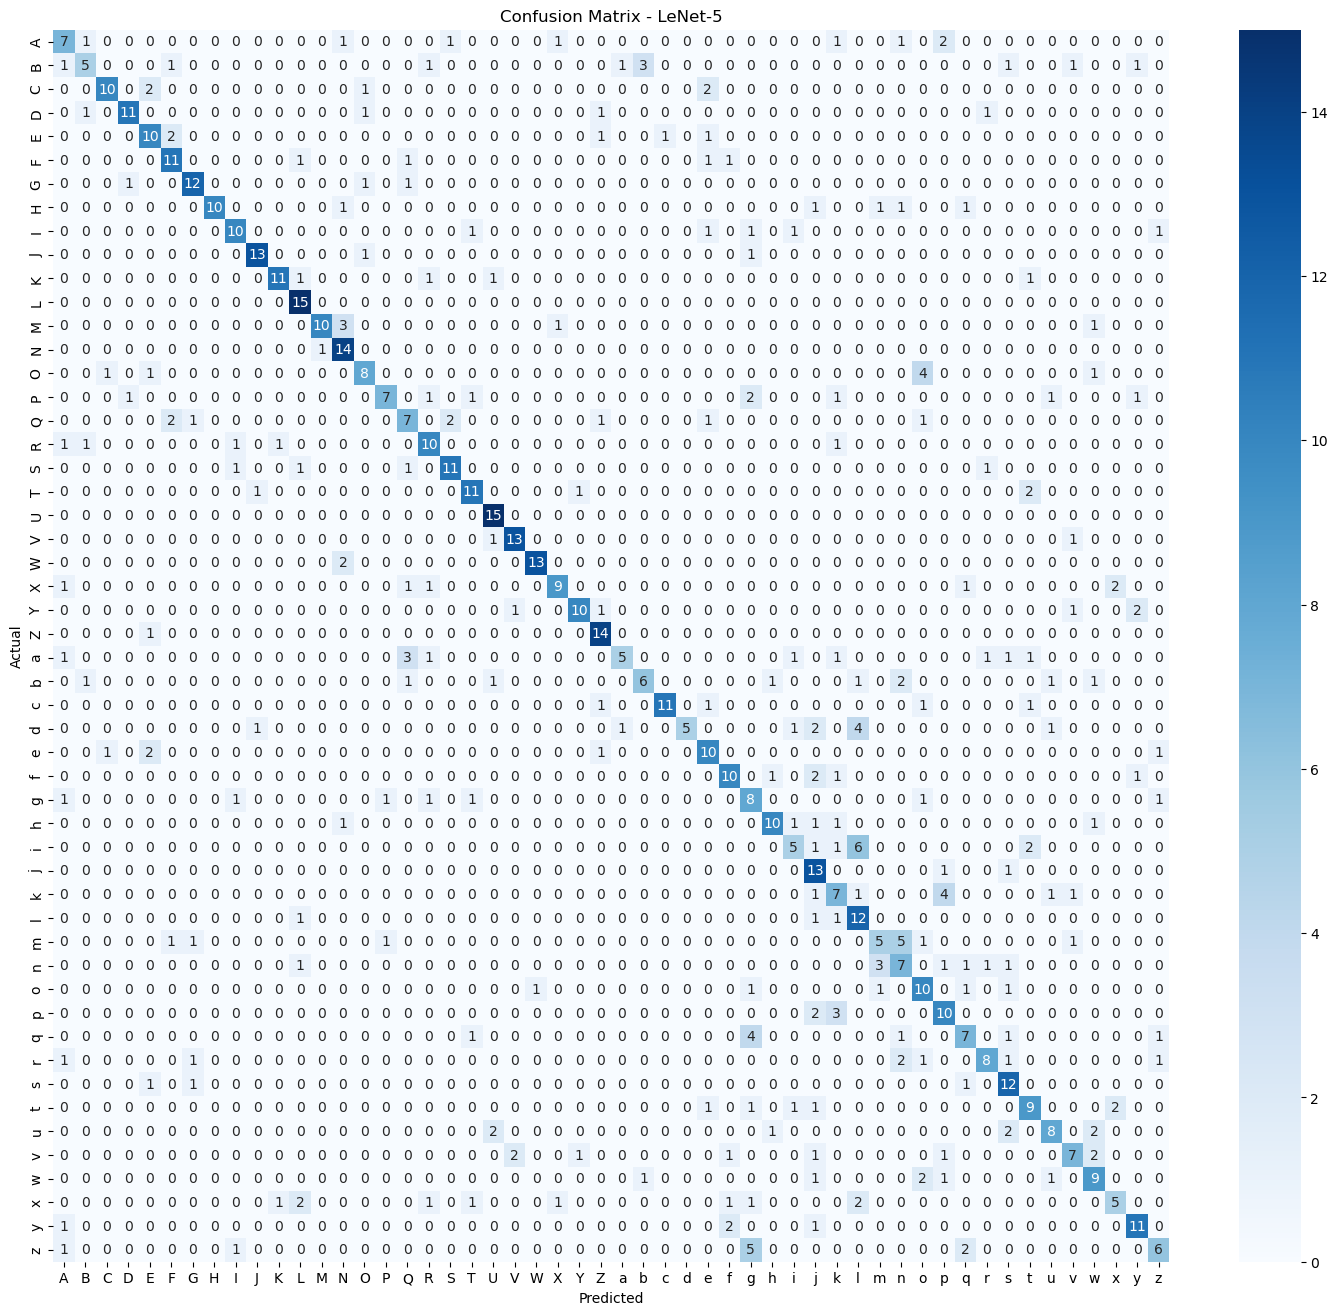

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


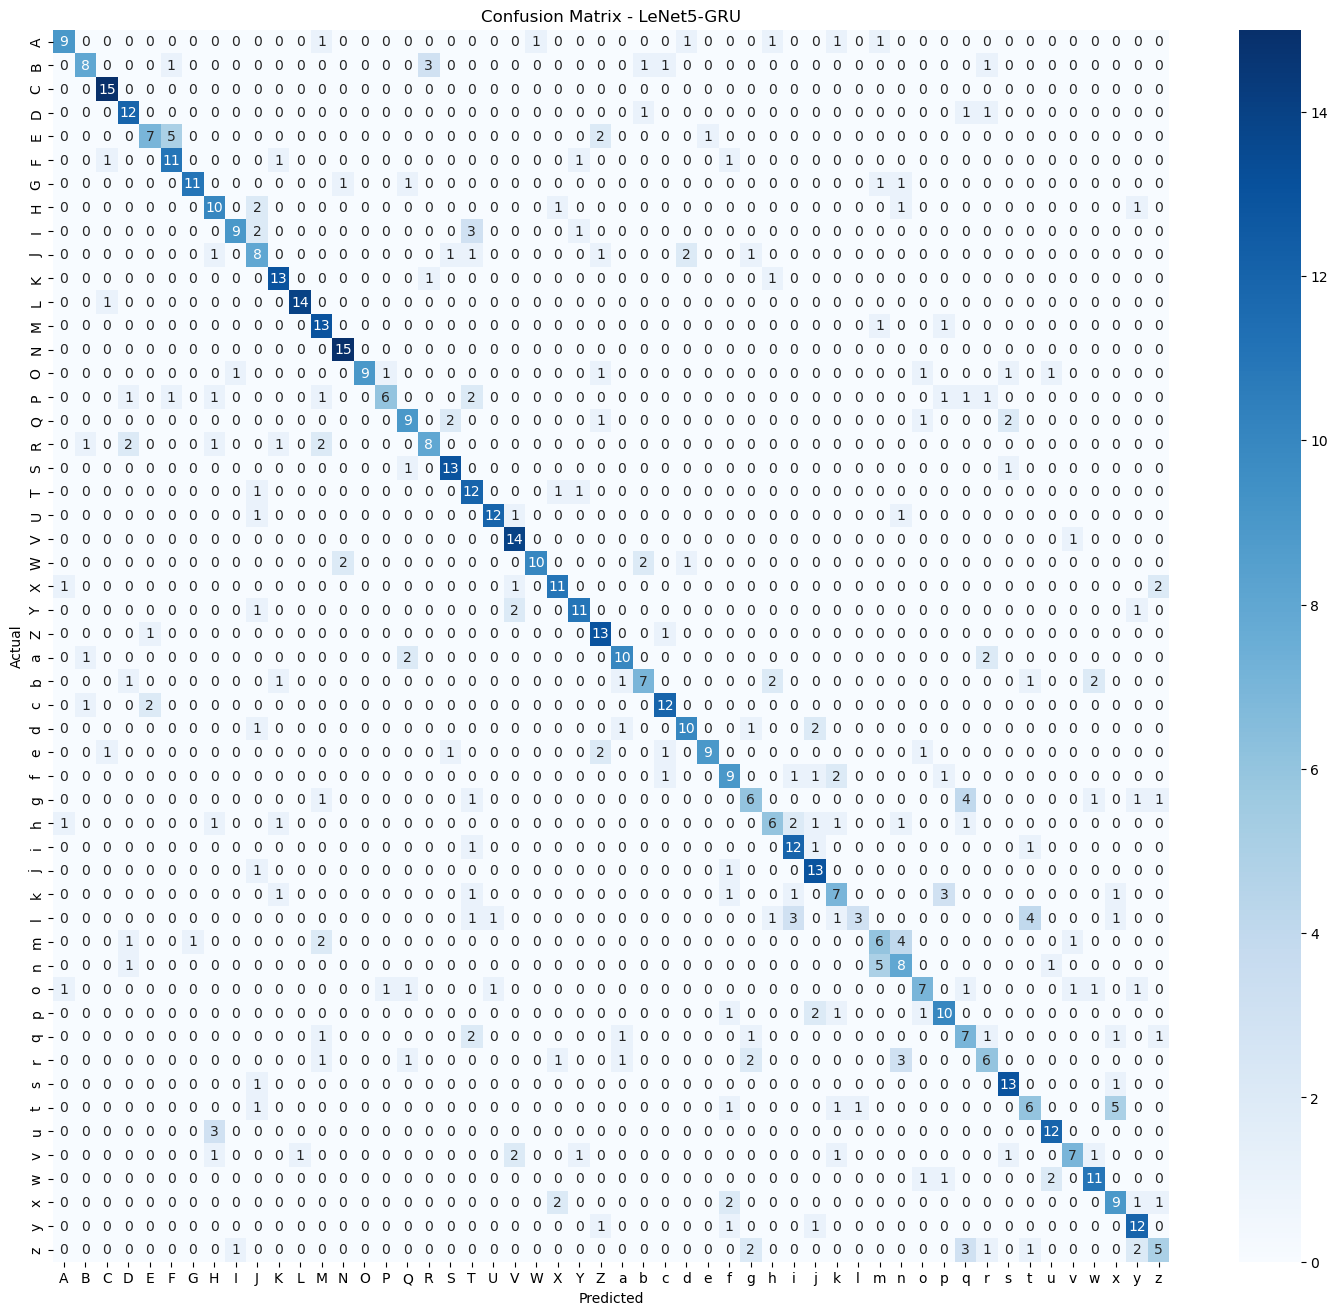

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


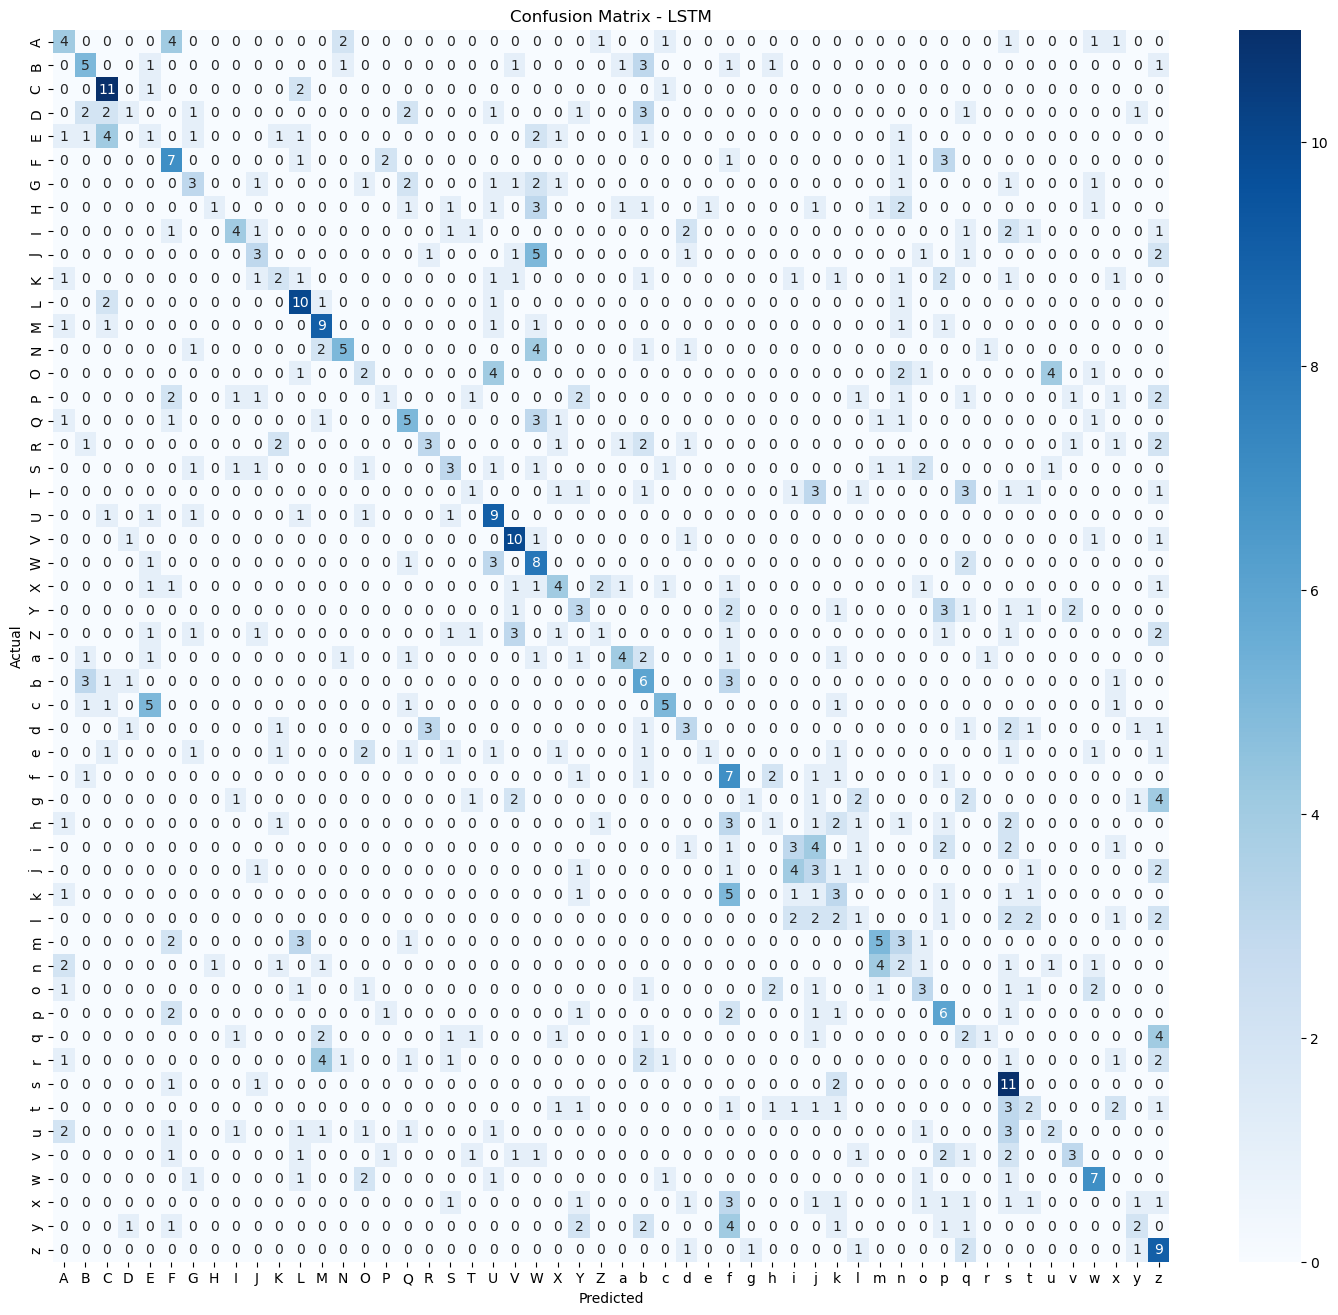

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step


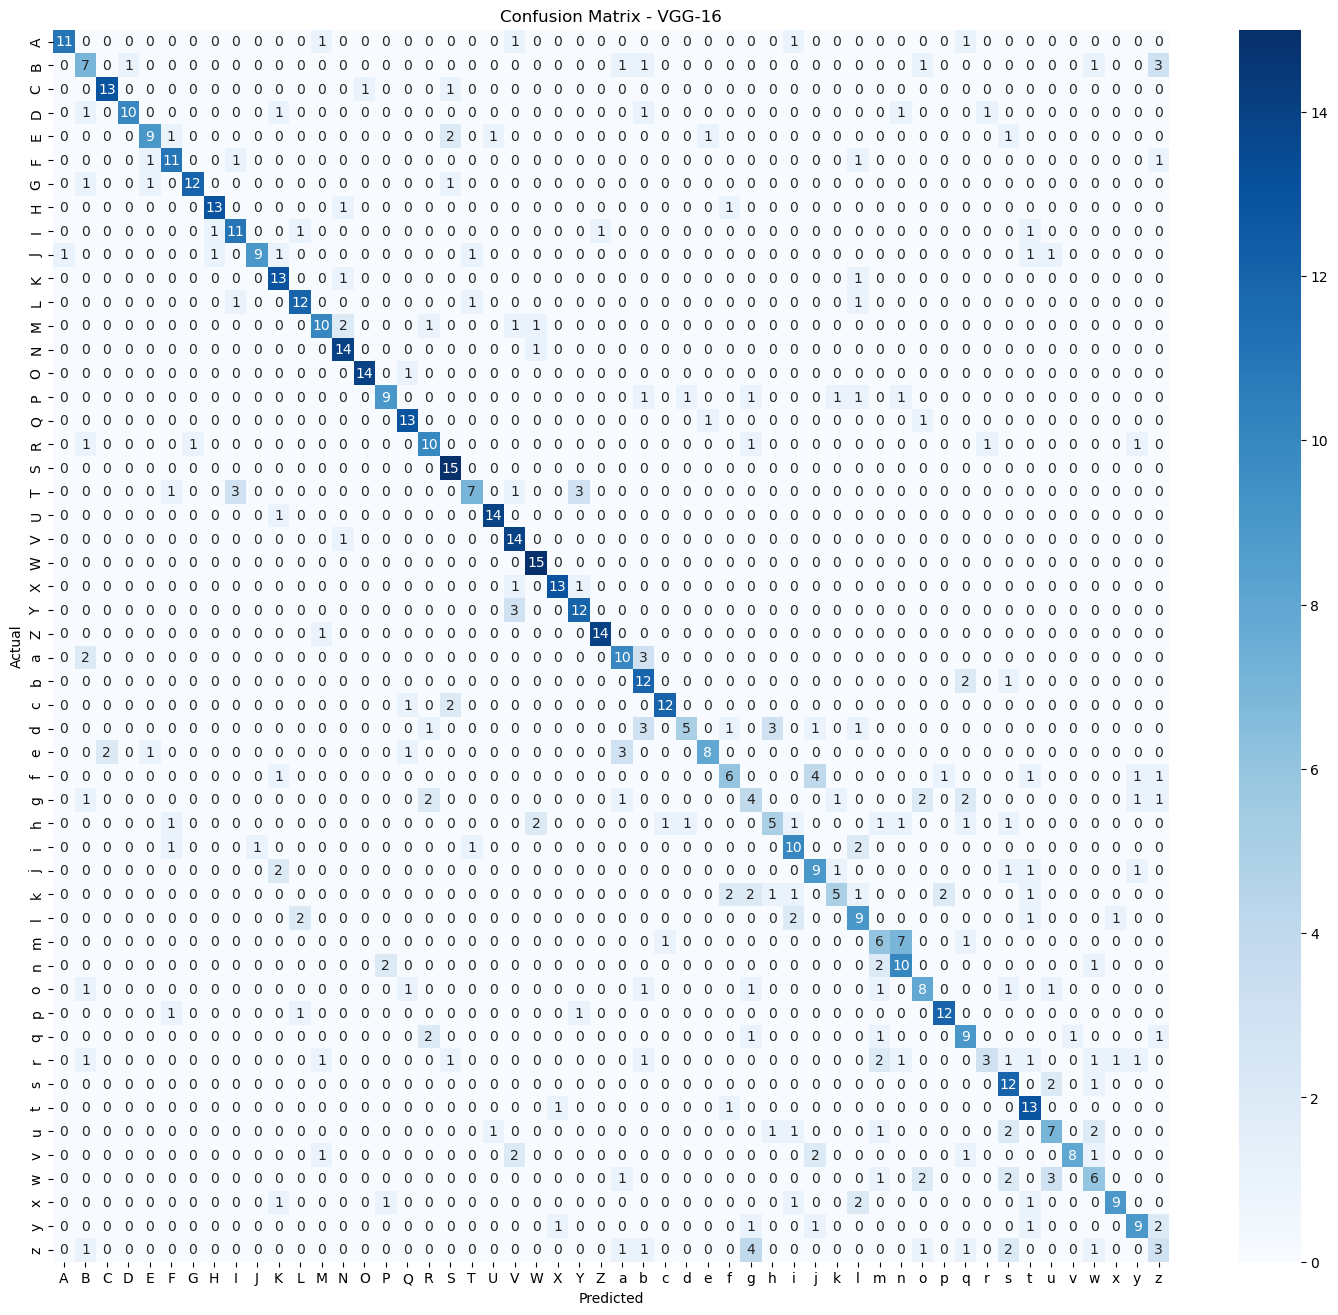

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step


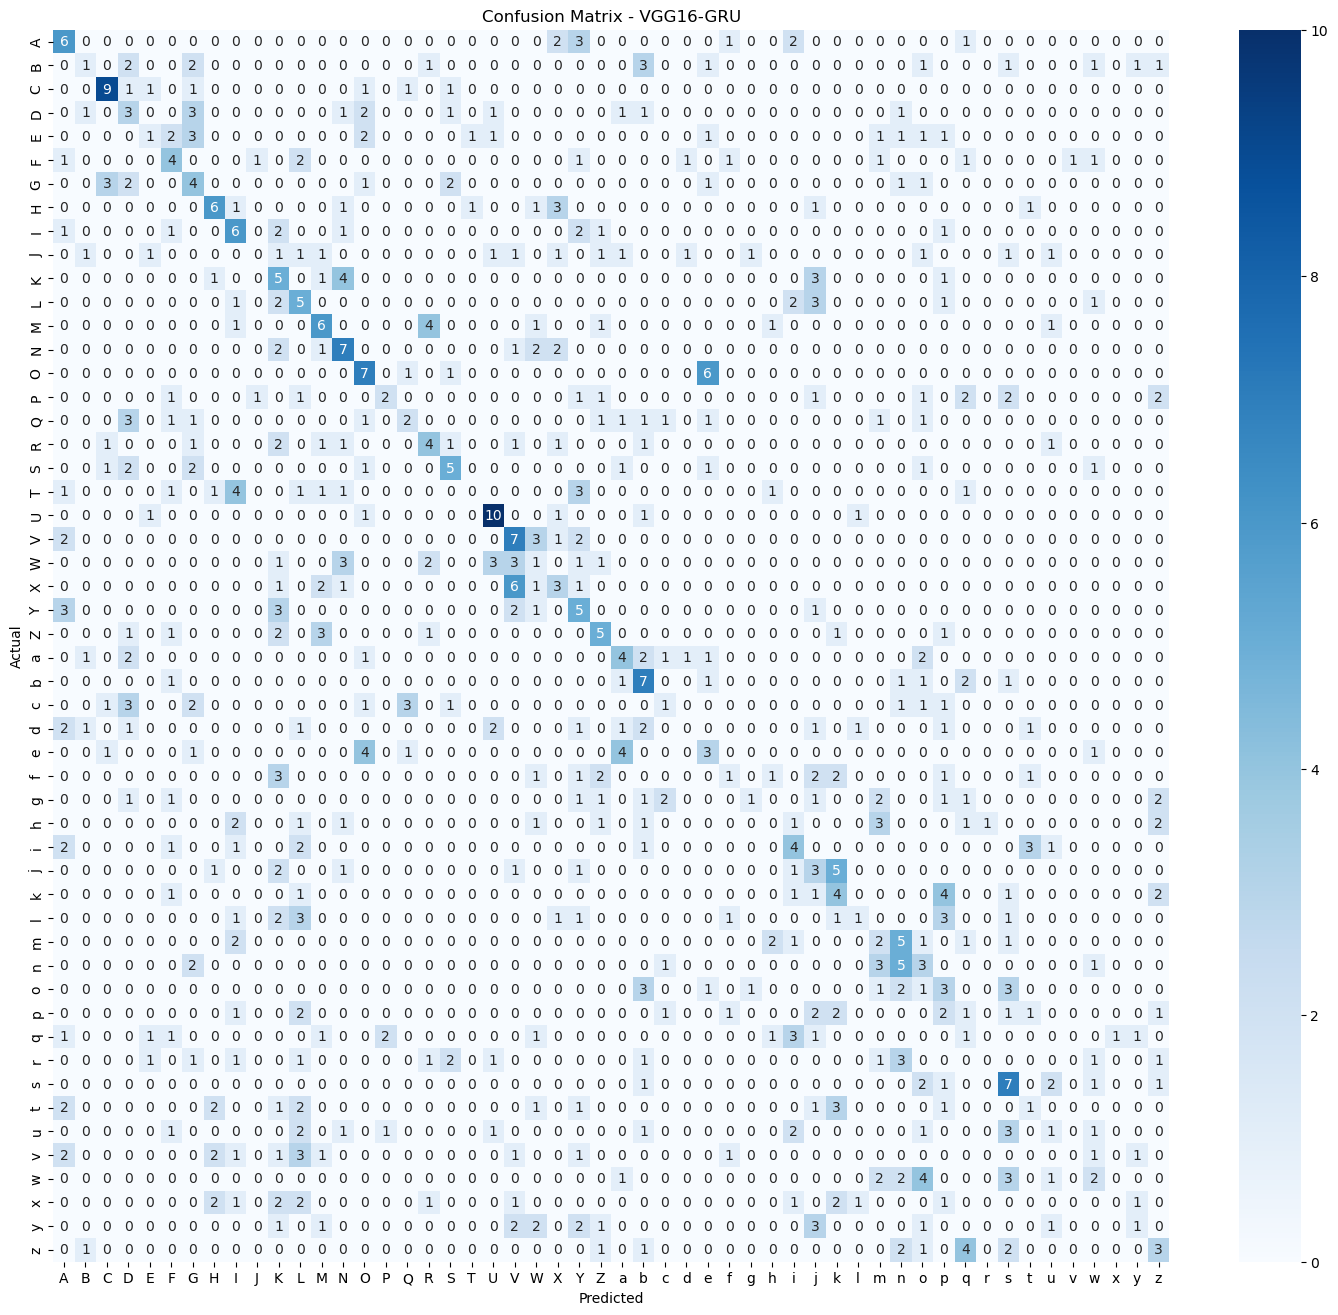

In [140]:
# --- Plot Confusion Matrices ---
for name, model in loaded_models.items(): # Iterate through loaded models
    plot_confusion_matrix(model, test_X, test_y, name)

In [196]:
# --- Plotting Log Loss and ROC-AUC ---
model_names_list = list(loaded_models.keys())  # List of model names for plotting
log_loss_values = metrics_df["Log Loss"].tolist()  # Extract Log Loss values from DataFrame
roc_auc_values = metrics_df["ROC-AUC"].tolist()  # Extract ROC-AUC values from DataFrame

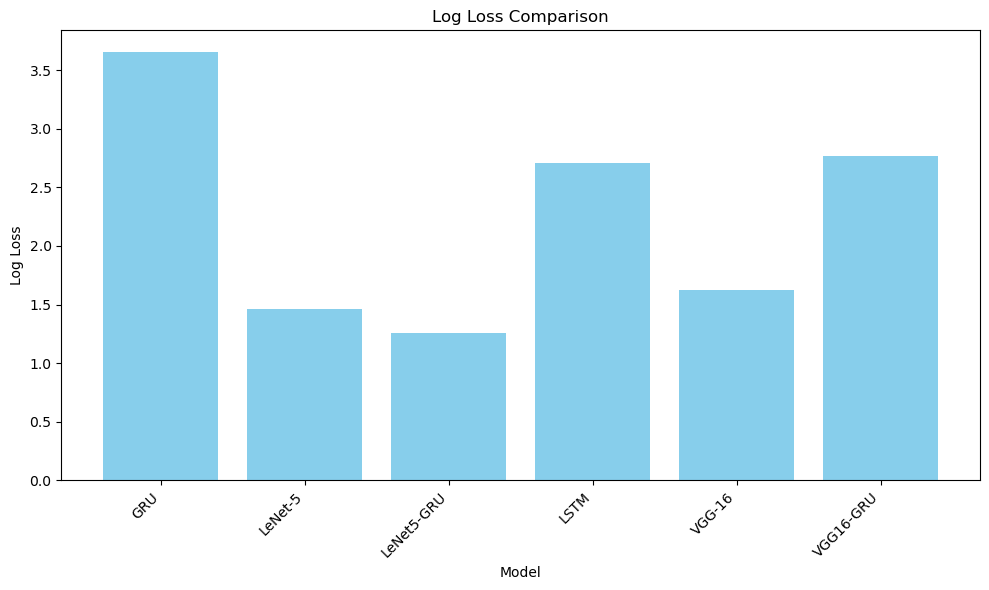

In [198]:
# Log Loss Plot
plt.figure(figsize=(10, 6))
plt.bar(model_names_list, log_loss_values, color='skyblue')
plt.xlabel("Model")
plt.ylabel("Log Loss")
plt.title("Log Loss Comparison")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

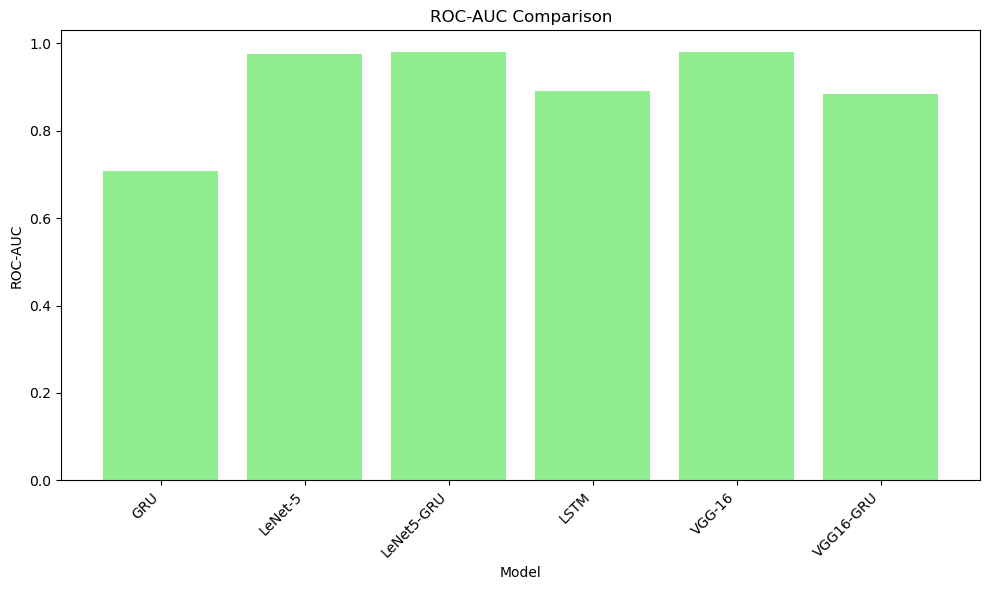

In [200]:
# ROC-AUC Plot
plt.figure(figsize=(10, 6))
plt.bar(model_names_list, roc_auc_values, color='lightgreen')
plt.xlabel("Model")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC Comparison")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

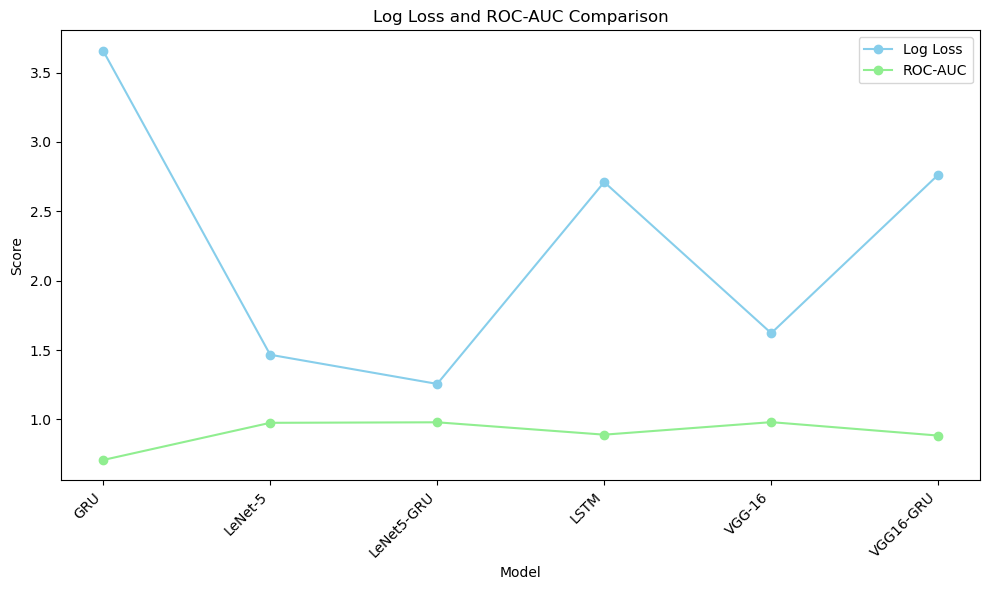

In [204]:
plt.figure(figsize=(10, 6))
plt.plot(model_names_list, log_loss_values, marker='o', linestyle='-', color='skyblue', label='Log Loss')
plt.plot(model_names_list, roc_auc_values, marker='o', linestyle='-', color='lightgreen', label='ROC-AUC')

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Log Loss and ROC-AUC Comparison")
plt.xticks(rotation=45, ha='right')
plt.legend()  # Show the legend
plt.tight_layout()
plt.show()

#### 🔶🔸 Model Error Analysis 🔹🔷

In [51]:
def load_test_data():
    """Simulated test dataset"""
    return np.random.rand(10, 64, 64, 3), np.random.randint(0, 52, 10)  # Dummy data (10 samples, 64x64x3)

X_test, y_test = load_test_data()

In [68]:
def compute_grap(model, model_name):
    """Compute and save GRAP (gradient-based) attributions."""
    try:
        print(f"ℹ️ Running GRAP for {model_name}...")  # Debugging line
        X_sample = tf.Variable(X_test[:1], dtype=tf.float32)  # Ensure TensorFlow variable

        with tf.GradientTape() as tape:
            tape.watch(X_sample)
            preds = model(X_sample)
        
        gradients = tape.gradient(preds, X_sample).numpy()
        
        # Save gradients
        np.save(f"save/no_tune/gradients/grap_{model_name}.npy", gradients)
        
        # Plot heatmap
        plt.imshow(gradients[0, :, :, 0], cmap="jet")
        plt.colorbar()
        plt.title(f"Gradient Heatmap - {model_name}")
        plt.savefig(f"save/no_tune/gradients/grap_plot_{model_name}.png")
        plt.close()
        print(f"✅ GRAP analysis saved for '{model_name}'")
    except Exception as e:
        print(f"❌ Error computing GRAP for '{model_name}': {e}")

In [70]:
# Run analysis for tuned models only
for model_name, model in loaded_models.items():
    print(f"Processing {model_name}...")
    compute_grap(model, model_name)
    print(f"Completed {model_name}\n")

Processing GRU...
ℹ️ Running GRAP for GRU...
✅ GRAP analysis saved for 'GRU'
Completed GRU

Processing LeNet-5...
ℹ️ Running GRAP for LeNet-5...
✅ GRAP analysis saved for 'LeNet-5'
Completed LeNet-5

Processing LeNet5-GRU...
ℹ️ Running GRAP for LeNet5-GRU...
✅ GRAP analysis saved for 'LeNet5-GRU'
Completed LeNet5-GRU

Processing LSTM...
ℹ️ Running GRAP for LSTM...
✅ GRAP analysis saved for 'LSTM'
Completed LSTM

Processing VGG-16...
ℹ️ Running GRAP for VGG-16...
✅ GRAP analysis saved for 'VGG-16'
Completed VGG-16

Processing VGG16-GRU...
ℹ️ Running GRAP for VGG16-GRU...
✅ GRAP analysis saved for 'VGG16-GRU'
Completed VGG16-GRU



In [80]:
def display_grap_images(model_names):
    """Display all saved GRAP images."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjust grid size as needed
    axes = axes.ravel()
    
    for i, model_name in enumerate(model_names):
        img_path = f"save/no_tune/gradients/grap_plot_{model_name}.png"
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            axes[i].imshow(img)
            axes[i].set_title(model_name)
            axes[i].axis("off")
        else:
            print(f"❌ GRAP image not found for {model_name}")
    
    plt.tight_layout()
    plt.show()

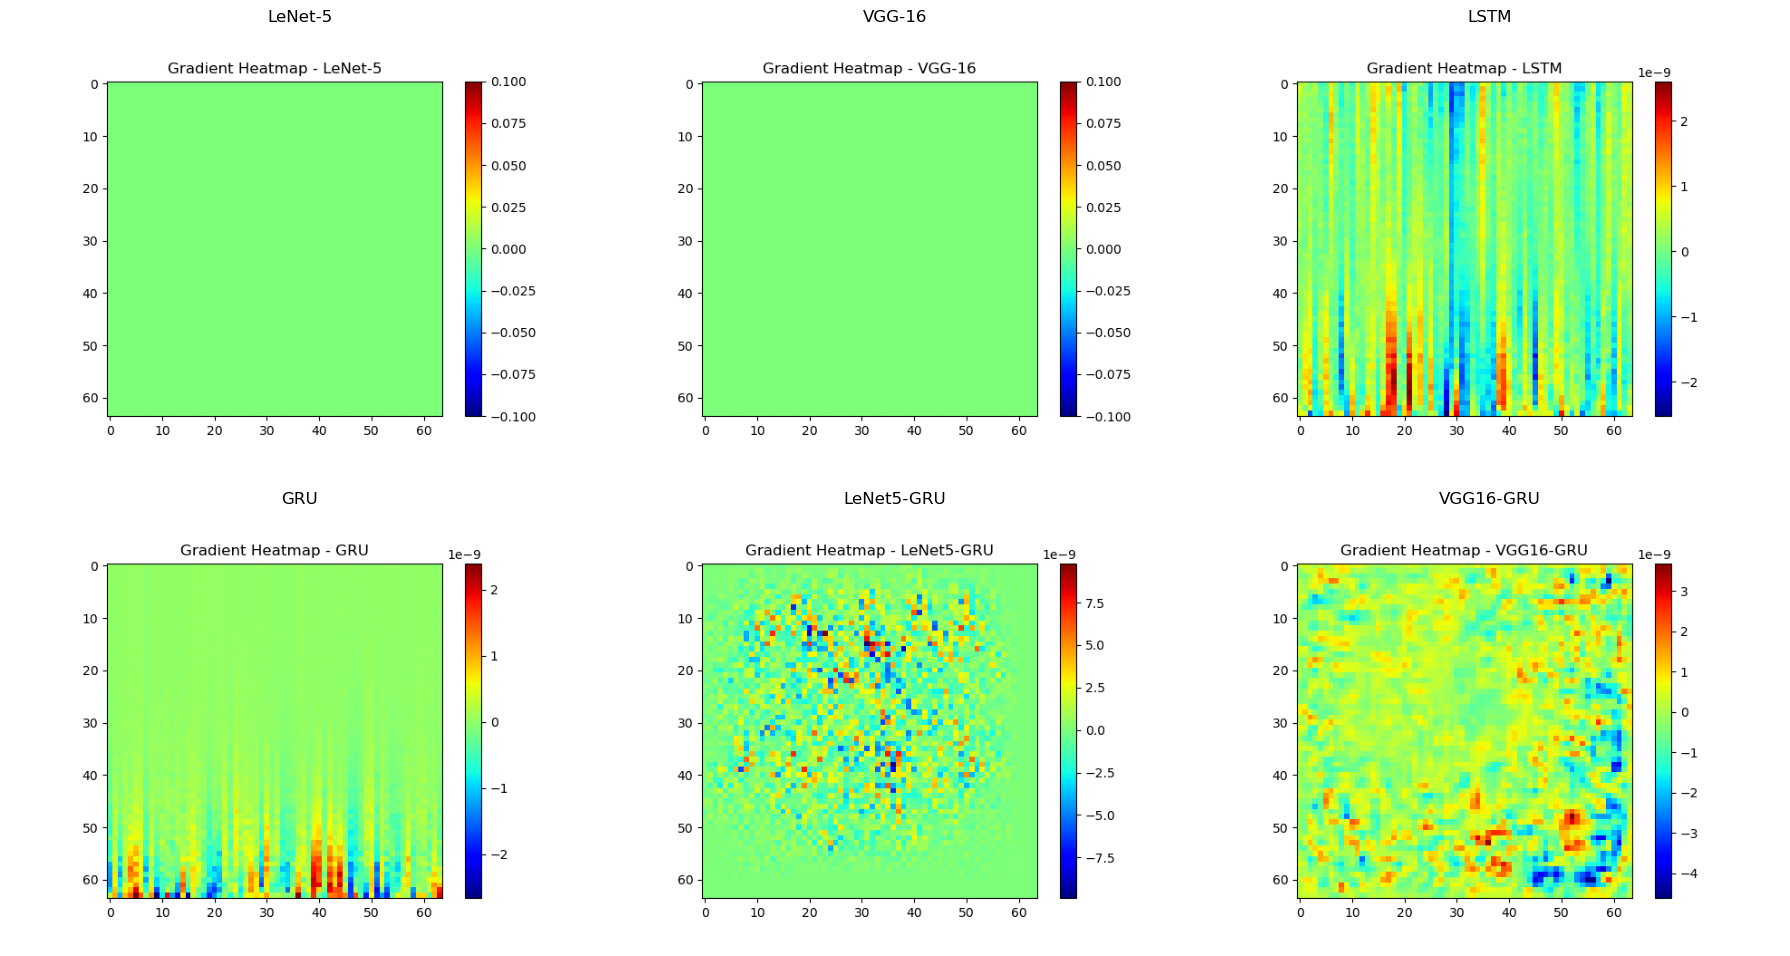

In [82]:
display_grap_images(model_names)